In [1]:
import json
import pandas as pd
import geopandas
from shapely.geometry import Polygon, LineString
import numpy as np

# Preprocessing Data

Ambil data dari overpass-eu dengan scraping data bangunan, jalanan, serta ruang hijau terbuka yang ada di Jakarta, karena masih mock atau semi jadi maka hanya tersedia di 1 kota yaitu Jakarta

In [3]:
def overpass_geom_to_gdf(json_file_path, tags_to_keep=None):
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    processed_features = []

    for element in data.get('elements', []):
        if element.get('type') == 'way' and 'geometry' in element:
            geom_coords = element['geometry']
            coords = [(point['lon'], point['lat']) for point in geom_coords]

            if len(coords) < 2:
                continue

            geometry = Polygon(coords) if coords[0] == coords[-1] and len(coords) >= 4 else LineString(coords)

            properties = {
                'osm_id': element['id'],
                'osm_type': element['type']
            }
            
            # --- OPTIMIZATION LOGIC ---
            # Only add tags that are in our 'tags_to_keep' list
            if 'tags' in element:
                if tags_to_keep:
                    for key, value in element['tags'].items():
                        if key in tags_to_keep:
                            properties[key] = value
                else: # If no list is provided, keep all tags
                    properties.update(element['tags'])
            
            feature = {
                'geometry': geometry,
                'properties': properties
            }
            processed_features.append(feature)

    if not processed_features:
        print("No processable 'way' features with geometry found.")
        return None
    
    gdf = geopandas.GeoDataFrame.from_features(processed_features, crs="EPSG:4326")
    return gdf

Konversi ke dataframe dengan mengambil tag yang diperlukan saja

In [4]:
if __name__ == '__main__':
    
    jalan_tags_to_keep = [
        'highway', 
        'name', 
        'oneway', 
        'lanes', 
        'surface', 
        'width',
        'footway'
    ]
    bangunan_tags_to_keep = [
        'building', 
        'name', 
        'building:levels', 
        'building:structure', 
        'building:walls', 
        'building:roof', 
        'building:condition',
        'addr:street', 
        'addr:city', 
        'capacity:persons', 
        'backup_generator'
    ]
    ruanghijau_tags_to_keep = [
        'landuse',
        'name',
        'leisure'
    ]

    # Replace this with the path to your downloaded file
    # For example: 'semua_bangunan_jakarta.geojson'
    filename_jalan = 'semua_jalan_jakarta.geojson' 
    filename_bangunan = 'semua_bangunan_jakarta.geojson'
    filename_ruanghijau = 'ruang_hijau_jakarta.geojson'

    # Convert the file
    df_jalan = overpass_geom_to_gdf(filename_jalan, tags_to_keep=jalan_tags_to_keep)
    df_bangunan = overpass_geom_to_gdf(filename_bangunan, tags_to_keep=bangunan_tags_to_keep)
    df_ruanghijau = overpass_geom_to_gdf(filename_ruanghijau, tags_to_keep=ruanghijau_tags_to_keep)

    print("Data Frame Info")
    df_jalan.info(verbose=True)
    df_bangunan.info(verbose=True)
    df_ruanghijau.info(verbose=True)

Data Frame Info
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 261337 entries, 0 to 261336
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  261337 non-null  geometry
 1   osm_id    261337 non-null  int64   
 2   osm_type  261337 non-null  object  
 3   highway   261337 non-null  object  
 4   lanes     103268 non-null  object  
 5   name      103328 non-null  object  
 6   oneway    110960 non-null  object  
 7   surface   120417 non-null  object  
 8   width     84701 non-null   object  
 9   footway   1367 non-null    object  
dtypes: geometry(1), int64(1), object(8)
memory usage: 19.9+ MB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1084189 entries, 0 to 1084188
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   geometry            1084189 non-null  geometry
 1   osm_id              1084189

Ambil data kualitas udara dari OpenAQ sesuai dengan beberapa kolom saja

In [5]:
columns_aqi = ['location_id', 'location_name', 'parameter', 'value', 'unit', 'datetimeLocal', 'latitude', 'longitude', ]

df_aqi_1 = pd.read_csv('openaq_location_8320_measurments.csv', usecols=columns_aqi)
df_aqi_2 = pd.read_csv('openaq_location_1367443_measurments.csv', usecols=columns_aqi)
df_aqi_3 = pd.read_csv('openaq_location_1563313_measurments.csv', usecols=columns_aqi)
df_aqi_4 = pd.read_csv('openaq_location_1894639_measurments.csv', usecols=columns_aqi)

df_aqi_1.info(verbose=True)
df_aqi_2.info(verbose=True)
df_aqi_3.info(verbose=True)
df_aqi_4.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_id    1000 non-null   int64  
 1   location_name  1000 non-null   object 
 2   parameter      1000 non-null   object 
 3   value          1000 non-null   int64  
 4   unit           1000 non-null   object 
 5   datetimeLocal  1000 non-null   object 
 6   latitude       1000 non-null   float64
 7   longitude      1000 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 62.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_id    6000 non-null   int64  
 1   location_name  6000 non-null   object 
 2   parameter      6000 non-null   object 
 3   value          6000 non-null   float64
 4   unit           60

Reshape dataframe agar lebih rapi 

In [6]:
all_aqi_df = [df_aqi_1, df_aqi_2, df_aqi_3, df_aqi_4]

aqi_df_row = pd.concat(all_aqi_df, ignore_index=True)

columns_keep_aqi = [
    'location_name',
    'parameter',
    'value',
    'datetimeLocal',
    'latitude',
    'longitude'
]

aqi_df_selected = aqi_df_row[columns_keep_aqi]

aqi_df_filtered = aqi_df_selected[aqi_df_selected['parameter'] == 'pm25'].copy()

aqi_df_clean = aqi_df_filtered.copy()

aqi_df_clean.rename(columns={
    'datetimeLocal': 'timestamp',
    'value': 'pm2_5',
    'location_name': 'station_name'
}, inplace=True)

aqi_df_clean['timestamp'] = pd.to_datetime(aqi_df_clean['timestamp'])

aqi_df_clean['pm2_5'] = pd.to_numeric(aqi_df_clean['pm2_5'])

aqi_df_clean.drop(columns=['parameter'], inplace=True)

In [7]:
aqi_df_clean.head()

,station_name,pm2_5,timestamp,latitude,longitude
0,Jakarta South,41.0,2022-10-04 08:00:00+07:00,-6.236704,106.793244
1,Jakarta South,34.0,2022-10-04 09:00:00+07:00,-6.236704,106.793244
2,Jakarta South,25.0,2022-10-04 10:00:00+07:00,-6.236704,106.793244
3,Jakarta South,40.0,2022-10-04 11:00:00+07:00,-6.236704,106.793244
4,Jakarta South,42.0,2022-10-04 12:00:00+07:00,-6.236704,106.793244


Gabungkan aqi dengan geojson df

In [8]:
# Get unique station information with coordinates
stations = aqi_df_clean[['station_name', 'latitude', 'longitude', 'timestamp']].drop_duplicates().reset_index(drop=True)

# Create the GeoDataFrame
stations_gdf = geopandas.GeoDataFrame(
    stations, geometry=geopandas.points_from_xy(stations.longitude, stations.latitude), crs="EPSG:4326"
)

# Convert to the right coordinate system
stations_gdf = stations_gdf.to_crs("EPSG:3857")
gdf_bangunan = df_bangunan.to_crs("EPSG:3857")
gdf_jalan = df_jalan.to_crs("EPSG:3857")
gdf_ruang_hijau = df_ruanghijau.to_crs("EPSG:3857")

In [9]:
stations_gdf["buffer_1km"] = stations_gdf.geometry.buffer(1000)

spatial_feat = []
for index, station in stations_gdf.iterrows():
    buffer = station['buffer_1km']

    buildings_buff = gdf_bangunan[gdf_bangunan.intersects(buffer)]
    roads_buff = gdf_jalan[gdf_jalan.intersects(buffer)]
    ruang_hijau_buff = gdf_ruang_hijau[gdf_ruang_hijau.intersects(buffer)]

    feature = {
        'station_name' : station['station_name'],
        'building_area_1km' : buildings_buff.geometry.area.sum() / 10000,
        'building_area_percent_1km' : (buildings_buff.geometry.area.sum() / buffer.area) * 100,
        'road_length_1km' : roads_buff.geometry.length.sum() / 1000,
        'green_space_area_1km' : ruang_hijau_buff.geometry.area.sum() / 10000,
        'green_space_area_percent_1km' : (ruang_hijau_buff.geometry.area.sum() / buffer.area) * 100
    }
    spatial_feat.append(feature)

spatial_feat_df = pd.DataFrame(spatial_feat)

In [10]:
print(spatial_feat_df)

       station_name  building_area_1km  building_area_percent_1km  \
0     Jakarta South          48.887394                  15.586367   
1     Jakarta South          48.887394                  15.586367   
2     Jakarta South          48.887394                  15.586367   
3     Jakarta South          48.887394                  15.586367   
4     Jakarta South          48.887394                  15.586367   
...             ...                ...                        ...   
3995        Jakarta           3.556745                   1.133968   
3996        Jakarta           3.556745                   1.133968   
3997        Jakarta           3.556745                   1.133968   
3998        Jakarta           3.556745                   1.133968   
3999        Jakarta           3.556745                   1.133968   

      road_length_1km  green_space_area_1km  green_space_area_percent_1km  
0          112.148629             15.752559                      5.022259  
1          112.1486

In [40]:
# Build station_info dataframe summarizing spatial features per station

# Aggregate spatial features (handle presence of both spatial_feat_df and spatial_feat_df_temp)
frames = []
if 'spatial_feat_df' in globals():
    frames.append(spatial_feat_df.copy())

spatial_all = pd.concat(frames, ignore_index=True)

agg_feats = (
    spatial_all
    .groupby('station_name')
    .agg({
        'building_area_1km': 'mean',
        'building_area_percent_1km': 'mean',
        'road_length_1km': 'mean',
        'green_space_area_1km': 'mean',
        'green_space_area_percent_1km': 'mean'
    })
    .rename(lambda c: f"{c}_mean", axis=1)
)

# Add sample counts
counts = spatial_all.groupby('station_name').size().rename('records_count')

station_info = agg_feats.join(counts)

# Merge approximate coordinates if available
if 'stations' in globals():
    coords = (
        stations.groupby('station_name')
        .agg({'latitude': 'mean', 'longitude': 'mean'})
    )
    station_info = station_info.join(coords, how='left')

station_info = station_info.reset_index()

station_info

,station_name,building_area_1km_mean,building_area_percent_1km_mean,road_length_1km_mean,green_space_area_1km_mean,green_space_area_percent_1km_mean,records_count,latitude,longitude
0,Depok,0.000000,0.000000,0.000000,0.000000,0.000000,1000,-6.409456,106.856152
1,Jakarta,3.556745,1.133968,10.053735,8.104892,2.584016,1000,-6.096570,106.961350
2,Jakarta South,48.887394,15.586367,112.148629,15.752559,5.022259,1000,-6.236704,106.793244
3,Qoryah Darussalam,88.085147,28.083464,81.320752,2.980764,0.950333,1000,-6.361241,106.841948


In [41]:
# Remove 'Depok' station from spatial feature datasets before merging
target_station_remove = "Depok"

if 'spatial_feat_df' in globals():
    before = len(spatial_feat_df)
    spatial_feat_df = spatial_feat_df[spatial_feat_df['station_name'] != target_station_remove].copy()
    after = len(spatial_feat_df)
    print(f"Filtered spatial_feat_df: {before - after} rows with '{target_station_remove}' removed.")

# Update station_info accordingly
if 'station_info' in globals():
    before_si = len(station_info)
    station_info = station_info[station_info['station_name'] != target_station_remove].reset_index(drop=True)
    after_si = len(station_info)
    print(f"Filtered station_info: {before_si - after_si} rows with '{target_station_remove}' removed.")

Filtered spatial_feat_df: 1000 rows with 'Depok' removed.
Filtered station_info: 1 rows with 'Depok' removed.


In [62]:
station_info.to_csv('station_info.csv', index=False)

In [42]:
final_df = pd.merge(aqi_df_clean, spatial_feat_df, on='station_name', how='left')

In [43]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001000 entries, 0 to 3000999
Data columns (total 10 columns):
 #   Column                        Dtype                    
---  ------                        -----                    
 0   station_name                  object                   
 1   pm2_5                         float64                  
 2   timestamp                     datetime64[ns, UTC+07:00]
 3   latitude                      float64                  
 4   longitude                     float64                  
 5   building_area_1km             float64                  
 6   building_area_percent_1km     float64                  
 7   road_length_1km               float64                  
 8   green_space_area_1km          float64                  
 9   green_space_area_percent_1km  float64                  
dtypes: datetime64[ns, UTC+07:00](1), float64(8), object(1)
memory usage: 229.0+ MB


# AQI

## Cleaning Data 

Menyesuaikan dengan model prophet yang memerlukan ds dan y

In [44]:
final_df['timestamp'] = final_df['timestamp'].dt.tz_localize(None)
final_df = final_df.drop_duplicates()

In [45]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3000000
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   station_name                  4000 non-null   object        
 1   pm2_5                         4000 non-null   float64       
 2   timestamp                     4000 non-null   datetime64[ns]
 3   latitude                      4000 non-null   float64       
 4   longitude                     4000 non-null   float64       
 5   building_area_1km             3000 non-null   float64       
 6   building_area_percent_1km     3000 non-null   float64       
 7   road_length_1km               3000 non-null   float64       
 8   green_space_area_1km          3000 non-null   float64       
 9   green_space_area_percent_1km  3000 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 343.8+ KB


In [46]:
import seaborn as sns

import matplotlib.pyplot as plt

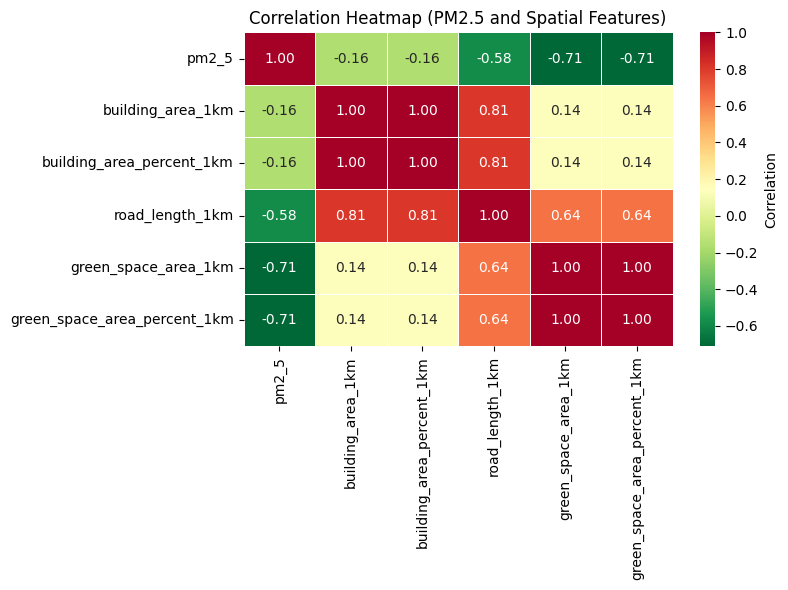

Correlation with pm2_5:
building_area_percent_1km      -0.157187
building_area_1km              -0.157187
road_length_1km                -0.581845
green_space_area_1km           -0.711742
green_space_area_percent_1km   -0.711742
Name: pm2_5, dtype: float64


In [27]:
numeric_cols = [
    'pm2_5',
    'building_area_1km',
    'building_area_percent_1km',
    'road_length_1km',
    'green_space_area_1km',
    'green_space_area_percent_1km',
]

corr = final_df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='RdYlGn_r',
    linewidths=.5,
    cbar_kws={'label': 'Correlation'}
)
plt.title('Correlation Heatmap (PM2.5 and Spatial Features)')
plt.tight_layout()
plt.show()

corr_pm25 = corr['pm2_5'].drop('pm2_5').sort_values(ascending=False)
print("Correlation with pm2_5:")
print(corr_pm25)

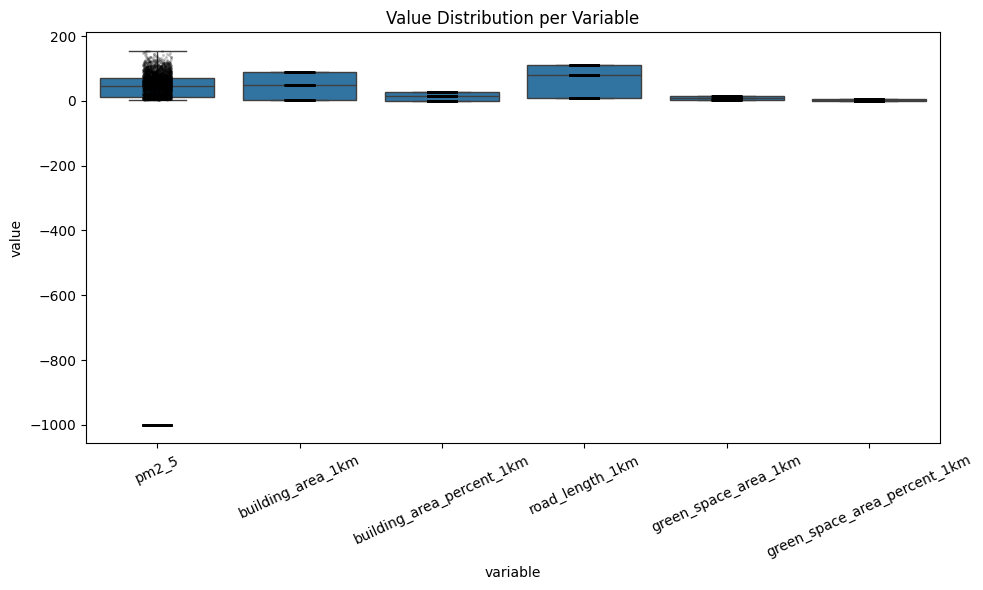

,count,mean,std,min,25%,50%,75%,max
pm2_5,4000.0,-124.827718,396.999088,-999.000000,11.317500,47.000000,69.785416,153.845837
building_area_1km,3000.0,46.843095,34.544597,3.556745,3.556745,48.887394,88.085147,88.085147
building_area_percent_1km,3000.0,14.934599,11.013570,1.133968,1.133968,15.586367,28.083464,28.083464
road_length_1km,3000.0,67.841039,42.763171,10.053735,10.053735,81.320752,112.148629,112.148629
green_space_area_1km,3000.0,8.946072,5.248755,2.980764,2.980764,8.104892,15.752559,15.752559
green_space_area_percent_1km,3000.0,2.852203,1.673418,0.950333,0.950333,2.584016,5.022259,5.022259


In [47]:
long_df = final_df[numeric_cols].melt(var_name='variable', value_name='value')

plt.figure(figsize=(10, 6))
sns.boxplot(data=long_df, x='variable', y='value', showfliers=False)
sns.stripplot(data=long_df, x='variable', y='value', color='black', alpha=0.25, size=2)
plt.title('Value Distribution per Variable')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

display(final_df[numeric_cols].describe().T)

Remove outlier pm2.5 negative

In [48]:
initial_count = len(final_df)
final_df = final_df[final_df['pm2_5'] >= 0].copy()
removed = initial_count - len(final_df)

unique_pm25 = np.sort(final_df['pm2_5'].unique())

In [49]:
final_df['hour'] = final_df['timestamp'].dt.hour
final_df['day'] = final_df['timestamp'].dt.day
final_df['month'] = final_df['timestamp'].dt.month
final_df['year'] = final_df['timestamp'].dt.year
final_df['day_of_week'] = final_df['timestamp'].dt.dayofweek
final_df['is_weekend'] = final_df['day_of_week'] >= 5

final_df[['timestamp', 'hour', 'day', 'month', 'year', 'day_of_week', 'is_weekend']].head()

,timestamp,hour,day,month,year,day_of_week,is_weekend
0,2022-10-04 08:00:00,8,4,10,2022,1,False
1000,2022-10-04 09:00:00,9,4,10,2022,1,False
2000,2022-10-04 10:00:00,10,4,10,2022,1,False
3000,2022-10-04 11:00:00,11,4,10,2022,1,False
4000,2022-10-04 12:00:00,12,4,10,2022,1,False


## Train XGBoost

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [58]:
# ...existing code...
from copy import deepcopy
import json

feature_cols = [
    'building_area_percent_1km',
    'road_length_1km',
    'green_space_area_percent_1km',
    'hour','day','month','year','day_of_week','is_weekend'
]

df_model = final_df.copy()
df_model['is_weekend'] = df_model['is_weekend'].astype(int)

X = df_model[feature_cols]
y = df_model['pm2_5']
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]; y = y[mask]

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42
)

base_params = dict(
    objective='reg:squarederror',
    n_estimators=1200,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    reg_alpha=0.3,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='rmse'
)

grid = {
    'max_depth': [4,6,8],
    'learning_rate': [0.03,0.05,0.07],
    'subsample': [0.7,0.85]
}

best_score = math.inf
best_params = {}
best_iter = None

for max_depth, lr, subsample in product(grid['max_depth'],
                                        grid['learning_rate'],
                                        grid['subsample']):
    params = {**base_params,
              'max_depth': max_depth,
              'learning_rate': lr,
              'subsample': subsample,
              'early_stopping_rounds': 75}
    model_tmp = xgboost.XGBRegressor(**params)
    model_tmp.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)
    # Fallback if early stopping not triggered
    used_iter = (model_tmp.best_iteration
                 if model_tmp.best_iteration is not None
                 else params['n_estimators'] - 1)
    val_pred = model_tmp.predict(X_val)
    rmse = mean_squared_error(y_val, val_pred, squared=False)
    if rmse < best_score:
        best_score = rmse
        best_params = dict(max_depth=max_depth,
                           learning_rate=lr,
                           subsample=subsample)
        best_iter = used_iter

print(f"Stage 1 Best RMSE: {best_score:.4f}")
print("Stage 1 Best params:", best_params)
print("Stage 1 Trees:", best_iter + 1)

# Optional small refinement around best (narrow search)
refined_grid = {
    'max_depth': [max(2, best_params['max_depth']-1),
                  best_params['max_depth'],
                  best_params['max_depth']+1],
    'learning_rate': [max(0.01, best_params['learning_rate']*0.8),
                      best_params['learning_rate'],
                      best_params['learning_rate']*1.2],
    'subsample': [best_params['subsample'],
                  min(0.95, best_params['subsample']+0.1)]
}

ref_best_score = best_score
ref_best_params = deepcopy(best_params)
ref_best_iter = best_iter

for max_depth, lr, subsample in product(refined_grid['max_depth'],
                                        refined_grid['learning_rate'],
                                        refined_grid['subsample']):
    # Clamp learning rate
    lr = round(float(lr), 4)
    subsample = round(float(subsample), 2)
    params = {**base_params,
              'max_depth': int(max_depth),
              'learning_rate': lr,
              'subsample': subsample,
              'early_stopping_rounds': 75}
    model_tmp = xgboost.XGBRegressor(**params)
    model_tmp.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)
    used_iter = (model_tmp.best_iteration
                 if model_tmp.best_iteration is not None
                 else params['n_estimators'] - 1)
    rmse = mean_squared_error(y_val, model_tmp.predict(X_val), squared=False)
    if rmse < ref_best_score:
        ref_best_score = rmse
        ref_best_params = dict(max_depth=int(max_depth),
                               learning_rate=lr,
                               subsample=subsample)
        ref_best_iter = used_iter

if ref_best_score < best_score:
    best_params = ref_best_params
    best_iter = ref_best_iter
    best_score = ref_best_score
    print(f"Refined Best RMSE: {best_score:.4f}")
    print("Refined params:", best_params)
    print("Refined trees:", best_iter + 1)
else:
    print("No refinement improvement; keeping Stage 1 params.")

final_model = xgboost.XGBRegressor(
    **base_params,
    **best_params
)
final_model.fit(X_train_full, y_train_full, verbose=False)

y_pred = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
mse = rmse_test**2
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MSE : {mse:.4f}")
print(f"Test R2  : {r2:.4f}")

importances = (
    pd.DataFrame({
        'feature': feature_cols,
        'importance': final_model.feature_importances_
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)
print("\nFeature Importance:")
print(importances)

# Save artifacts (optional)
# os.makedirs("models_xgb", exist_ok=True)
# final_model.save_model("models_xgb/pm25_xgb_tuned.json")
# importances.to_csv("models_xgb/pm25_feature_importance.csv", index=False)
# with open("models_xgb/pm25_features.json","w") as f:
#     json.dump(feature_cols, f, indent=2)
# ...existing code...

Stage 1 Best RMSE: 11.3026
Stage 1 Best params: {'max_depth': 8, 'learning_rate': 0.03, 'subsample': 0.85}
Stage 1 Trees: 253
Refined Best RMSE: 11.2129
Refined params: {'max_depth': 9, 'learning_rate': 0.03, 'subsample': 0.85}
Refined trees: 217
Test RMSE: 10.1808
Test MSE : 103.6489
Test R2  : 0.8782

Feature Importance:
                        feature  importance
0  green_space_area_percent_1km    0.630985
1     building_area_percent_1km    0.212854
2                         month    0.033734
3                           day    0.030928
4                    is_weekend    0.030670
5                          hour    0.022248
6                   day_of_week    0.021822
7               road_length_1km    0.013834
8                          year    0.002925


In [59]:
import os

In [60]:
os.makedirs("models_xgb", exist_ok=True)

model_path = "models_xgb/pm25_xgb_model.json"
features_path = "models_xgb/pm25_features.json"
importance_path = "models_xgb/pm25_feature_importance.csv"

model_all.save_model(model_path)
importances.to_csv(importance_path, index=False)

with open(features_path, 'w', encoding='utf-8') as f:
    json.dump(feature_cols, f, ensure_ascii=False, indent=2)

print(f"Saved model to {model_path}")
print(f"Saved feature list to {features_path}")
print(f"Saved feature importance to {importance_path}")

Saved model to models_xgb/pm25_xgb_model.json
Saved feature list to models_xgb/pm25_features.json
Saved feature importance to models_xgb/pm25_feature_importance.csv


## Prophet

In [31]:
import torch
from neuralprophet import NeuralProphet

In [32]:
prophet_df = final_df[['station_name', 'timestamp', 'pm2_5']].rename(columns={'timestamp': 'ds', 'pm2_5': 'y'})

In [33]:
models = {}
for station, df_s in prophet_df[['station_name','ds','y']].dropna().groupby('station_name'):
    df_s = df_s[['ds','y']].sort_values('ds').reset_index(drop=True)
    freq = pd.infer_freq(df_s['ds'])
    if freq is None:
        freq = 'H' 

    m = NeuralProphet(weekly_seasonality=True, daily_seasonality=True, epochs=50)
    m.fit(df_s, freq=freq)
    models[station] = {'model': m, 'freq': freq}

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 90.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (32) is too small than the required number                     for the learning rate finder (226). The results might not be optimal.


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\LENOVO\anaconda3\envs\py_gpu\lib\site-packages\lightning_fabric\utilities\cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 1044S corresponds to 37.1% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq H. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (32) is too small than the required number                     for the learning rate finder

Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\LENOVO\anaconda3\envs\py_gpu\lib\site-packages\lightning_fabric\utilities\cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 94.357% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (20) is too small than the required number                     for the learning rate finder (215). The results might not be optimal.


Finding best initial lr:   0%|          | 0/215 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\LENOVO\anaconda3\envs\py_gpu\lib\site-packages\lightning_fabric\utilities\cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 92.6% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (32) is too small than the required number                     for the learning rate finder (226). The results might not be optimal.


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\LENOVO\anaconda3\envs\py_gpu\lib\site-packages\lightning_fabric\utilities\cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

Training: 0it [00:00, ?it/s]

In [ ]:
import os
from neuralprophet import save

os.makedirs("models_np", exist_ok=True)

saved_paths = {}
for station, meta in models.items():
    model = meta['model']
    safe_name = "".join(ch if ch.isalnum() or ch in ('_', '-') else '_' for ch in station)
    path = os.path.join("models_np", f"{safe_name}.np")
    save(model, path)
    meta['path'] = path
    saved_paths[station] = path

for k, v in saved_paths.items():
    print(f"{k}: {v}")

# Temperature

In [14]:
import torch
import xgboost

In [15]:
aqi_df_row = pd.concat(all_aqi_df, ignore_index=True)

columns_keep_aqi = [
    'location_name',
    'parameter',
    'value',
    'datetimeLocal',
    'latitude',
    'longitude'
]

aqi_df_temp = aqi_df_row[columns_keep_aqi]

aqi_df_filtered_temp = aqi_df_temp[aqi_df_temp['parameter'] == 'pm25'].copy()

aqi_df_clean_temp = aqi_df_filtered_temp.copy()

aqi_df_clean_temp.rename(columns={
    'datetimeLocal': 'timestamp',
    'value': 'temperature',
    'location_name': 'station_name'
}, inplace=True)

aqi_df_clean_temp['timestamp'] = pd.to_datetime(aqi_df_clean_temp['timestamp'])

aqi_df_clean_temp['temperature'] = pd.to_numeric(aqi_df_clean_temp['temperature'])

aqi_df_clean_temp.drop(columns=['parameter'], inplace=True)

In [16]:
aqi_df_clean_temp.head()

,station_name,temperature,timestamp,latitude,longitude
0,Jakarta South,41.0,2022-10-04 08:00:00+07:00,-6.236704,106.793244
1,Jakarta South,34.0,2022-10-04 09:00:00+07:00,-6.236704,106.793244
2,Jakarta South,25.0,2022-10-04 10:00:00+07:00,-6.236704,106.793244
3,Jakarta South,40.0,2022-10-04 11:00:00+07:00,-6.236704,106.793244
4,Jakarta South,42.0,2022-10-04 12:00:00+07:00,-6.236704,106.793244


In [17]:
stations_temp = aqi_df_clean_temp[['station_name', 'latitude', 'longitude', 'timestamp']].drop_duplicates().reset_index(drop=True)

# Create the GeoDataFrame
stations_gdf_temp = geopandas.GeoDataFrame(
    stations_temp, geometry=geopandas.points_from_xy(stations_temp.longitude, stations_temp.latitude), crs="EPSG:4326"
)

# Convert to the right coordinate system
stations_gdf_temp = stations_gdf_temp.to_crs("EPSG:3857")
gdf_bangunan = df_bangunan.to_crs("EPSG:3857")
gdf_jalan = df_jalan.to_crs("EPSG:3857")
gdf_ruang_hijau = df_ruanghijau.to_crs("EPSG:3857")

In [20]:
stations_gdf_temp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   station_name  4000 non-null   object                   
 1   latitude      4000 non-null   float64                  
 2   longitude     4000 non-null   float64                  
 3   timestamp     4000 non-null   datetime64[ns, UTC+07:00]
 4   geometry      4000 non-null   geometry                 
 5   buffer_1km    4000 non-null   geometry                 
dtypes: datetime64[ns, UTC+07:00](1), float64(2), geometry(2), object(1)
memory usage: 187.6+ KB


In [21]:
stations_gdf_temp["buffer_1km"] = stations_gdf_temp.geometry.buffer(1000)

spatial_feat = []
for index, station in stations_gdf_temp.iterrows():
    buffer = station['buffer_1km']

    buildings_buff_temp = gdf_bangunan[gdf_bangunan.intersects(buffer)]
    roads_buff_temp = gdf_jalan[gdf_jalan.intersects(buffer)]
    ruang_hijau_buff_temp = gdf_ruang_hijau[gdf_ruang_hijau.intersects(buffer)]

    feature = {
        'station_name' : station['station_name'],
        'building_area_1km' : buildings_buff_temp.geometry.area.sum() / 10000,
        'building_area_percent_1km' : (buildings_buff_temp.geometry.area.sum() / buffer.area) * 100,
        'road_length_1km' : roads_buff_temp.geometry.length.sum() / 1000,
        'green_space_area_1km' : ruang_hijau_buff_temp.geometry.area.sum() / 10000,
        'green_space_area_percent_1km' : (ruang_hijau_buff_temp.geometry.area.sum() / buffer.area) * 100
    }
    spatial_feat.append(feature)

spatial_feat_df_temp = pd.DataFrame(spatial_feat)

In [22]:
final_df_temp = pd.merge(aqi_df_clean_temp, spatial_feat_df_temp, on='station_name', how='left')

In [23]:
final_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 10 columns):
 #   Column                        Dtype                    
---  ------                        -----                    
 0   station_name                  object                   
 1   temperature                   float64                  
 2   timestamp                     datetime64[ns, UTC+07:00]
 3   latitude                      float64                  
 4   longitude                     float64                  
 5   building_area_1km             float64                  
 6   building_area_percent_1km     float64                  
 7   road_length_1km               float64                  
 8   green_space_area_1km          float64                  
 9   green_space_area_percent_1km  float64                  
dtypes: datetime64[ns, UTC+07:00](1), float64(8), object(1)
memory usage: 305.2+ MB


Latih dengan model booster, ubah timestamp ke bentuk tabel hour, month, day, year

In [34]:
final_df_temp['hour'] = final_df_temp['timestamp'].dt.hour
final_df_temp['day'] = final_df_temp['timestamp'].dt.day
final_df_temp['month'] = final_df_temp['timestamp'].dt.month
final_df_temp['year'] = final_df_temp['timestamp'].dt.year
final_df_temp['dayofweek'] = final_df_temp['timestamp'].dt.dayofweek

final_df_temp['is_weekend'] = (final_df_temp['dayofweek'] >= 5).astype(int)

print(final_df_temp[['station_name', 'temperature', 'timestamp', 'hour', 'day', 'month', 'year', 'dayofweek', 'is_weekend']].head())

    station_name  temperature                 timestamp  hour  day  month  \
0  Jakarta South         41.0 2022-10-04 08:00:00+07:00     8    4     10   
1  Jakarta South         41.0 2022-10-04 08:00:00+07:00     8    4     10   
2  Jakarta South         41.0 2022-10-04 08:00:00+07:00     8    4     10   
3  Jakarta South         41.0 2022-10-04 08:00:00+07:00     8    4     10   
4  Jakarta South         41.0 2022-10-04 08:00:00+07:00     8    4     10   

   year  dayofweek  is_weekend  
0  2022          1           0  
1  2022          1           0  
2  2022          1           0  
3  2022          1           0  
4  2022          1           0  


In [35]:
final_df_temp.head()

,station_name,temperature,timestamp,latitude,longitude,building_area_1km,building_area_percent_1km,road_length_1km,green_space_area_1km,green_space_area_percent_1km,hour,day,month,year,dayofweek,is_weekend
0,Jakarta South,41.0,2022-10-04 08:00:00+07:00,-6.236704,106.793244,48.887394,15.586367,112.148629,15.752559,5.022259,8,4,10,2022,1,0
1,Jakarta South,41.0,2022-10-04 08:00:00+07:00,-6.236704,106.793244,48.887394,15.586367,112.148629,15.752559,5.022259,8,4,10,2022,1,0
2,Jakarta South,41.0,2022-10-04 08:00:00+07:00,-6.236704,106.793244,48.887394,15.586367,112.148629,15.752559,5.022259,8,4,10,2022,1,0
3,Jakarta South,41.0,2022-10-04 08:00:00+07:00,-6.236704,106.793244,48.887394,15.586367,112.148629,15.752559,5.022259,8,4,10,2022,1,0
4,Jakarta South,41.0,2022-10-04 08:00:00+07:00,-6.236704,106.793244,48.887394,15.586367,112.148629,15.752559,5.022259,8,4,10,2022,1,0


In [36]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [37]:
feature_columns = [
    'building_area_1km', 'building_area_percent_1km', 'road_length_1km',
    'green_space_area_1km', 'green_space_area_percent_1km',
    'hour', 'day', 'month', 'year', 'dayofweek', 'is_weekend'
]

X = final_df_temp[feature_columns].dropna()
y = final_df_temp.loc[X.index, 'temperature']

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42
)

# Scale features (fit on train, apply to test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Torch tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train).view(-1, 1)
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test).view(-1, 1)

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloaders
batch_size = 512
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# MLP model
class MLPRegressor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 1),
        )
    def forward(self, x): return self.net(x)

model = MLPRegressor(in_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scaler_amp = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# Train
epochs = 60
model.train()
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            preds = model(xb)
            loss = criterion(preds, yb)

        scaler_amp.scale(loss).backward()
        scaler_amp.step(optimizer)
        scaler_amp.update()

        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} - Train MSE: {epoch_loss:.4f}")

# Evaluate
model.eval()
with torch.no_grad():
    preds_list = []
    targets_list = []
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb).cpu().numpy().ravel()
        preds_list.append(out)
        targets_list.append(yb.numpy().ravel())

y_pred = np.concatenate(preds_list)
y_true = np.concatenate(targets_list)

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Temperature Prediction Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


WARNING - (py.warnings._showwarnmsg) - C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12952\1357256880.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

WARNING - (py.warnings._showwarnmsg) - C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12952\1357256880.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):



Epoch 1/60 - Train MSE: 29344.7588
Epoch 10/60 - Train MSE: 2484.4021
Epoch 20/60 - Train MSE: 1380.4700
Epoch 30/60 - Train MSE: 988.8875
Epoch 40/60 - Train MSE: 816.0897
Epoch 50/60 - Train MSE: 730.9442
Epoch 60/60 - Train MSE: 710.7930
Temperature Prediction Model Performance:
Mean Squared Error: 594.8389
R² Score: 0.9962


In [38]:
feature_columns = [
    'building_area_1km', 'building_area_percent_1km', 'road_length_1km',
    'green_space_area_1km', 'green_space_area_percent_1km',
    'hour', 'day', 'month', 'year', 'dayofweek', 'is_weekend'
]

X = final_df_temp[feature_columns].dropna()
y = final_df_temp.loc[X.index, 'temperature']

# Filter out -999 values which are likely missing data placeholders
mask = y != -999
X = X[mask]
y = y[mask]

# Hold-out test, plus internal validation for early stopping
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Tuned XGBRegressor with stronger regularization and subsampling
base_params = dict(
    objective='reg:squarederror',
    n_estimators=2000,            # large; early_stopping will pick best
    learning_rate=0.05,           # smaller LR
    max_depth=6,                  # shallower trees
    min_child_weight=3,           # min data per leaf
    gamma=0.0,                    # min loss reduction to split
    subsample=0.8,                # row subsample
    colsample_bytree=0.8,         # feature subsample per tree
    reg_lambda=2.0,               # L2 regularization
    reg_alpha=0.5,                # L1 regularization
    random_state=42,
    n_jobs=-1,
    tree_method='hist',           # change to 'gpu_hist' if GPU XGBoost is installed
    early_stopping_rounds=100,
    eval_metric='rmse'
)

temp_model = xgboost.XGBRegressor(**base_params)

# Make sure validation set is properly passed for early stopping
temp_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

# Get best iteration
best_iter = temp_model.best_iteration

# Refit on train+val with best number of trees (remove early_stopping_rounds for final fit)
final_params = {k: v for k, v in base_params.items() if k != 'early_stopping_rounds'}
final_model = xgboost.XGBRegressor(**{**final_params, "n_estimators": best_iter + 1})
final_model.fit(X_train_full, y_train_full, verbose=False)

# Evaluate on the untouched test set
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Temperature Prediction Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Best trees (early stopping): {best_iter + 1}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

[0]	validation_0-rmse:29.73560	validation_1-rmse:29.74463
[100]	validation_0-rmse:12.22146	validation_1-rmse:12.22449
[200]	validation_0-rmse:10.15971	validation_1-rmse:10.16730
[300]	validation_0-rmse:8.97660	validation_1-rmse:8.98587
[400]	validation_0-rmse:8.26799	validation_1-rmse:8.27490
[500]	validation_0-rmse:7.62682	validation_1-rmse:7.62998
[600]	validation_0-rmse:7.11166	validation_1-rmse:7.11287
[700]	validation_0-rmse:6.75262	validation_1-rmse:6.75242
[800]	validation_0-rmse:6.40610	validation_1-rmse:6.40542
[900]	validation_0-rmse:6.16379	validation_1-rmse:6.16331
[1000]	validation_0-rmse:6.00024	validation_1-rmse:5.99952
[1100]	validation_0-rmse:5.82665	validation_1-rmse:5.82618
[1200]	validation_0-rmse:5.68055	validation_1-rmse:5.68008
[1300]	validation_0-rmse:5.54538	validation_1-rmse:5.54486
[1400]	validation_0-rmse:5.43257	validation_1-rmse:5.43257
[1500]	validation_0-rmse:5.30754	validation_1-rmse:5.30847
[1600]	validation_0-rmse:5.24154	validation_1-rmse:5.24290
[17